<a href="https://colab.research.google.com/github/josephxlp/FinMLA/blob/main/CreditCardSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
!pip install kneed --q

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from google.colab import drive
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

In [112]:
drive.mount('/content/drive', force_remount=True)
rootpath = Path("/content/drive/MyDrive/portfolio/FinMLA")
datapath = rootpath / 'data'
os.chdir(rootpath)

creditcard_df = pd.read_csv(datapath/'marketing_data.csv')
df = creditcard_df.copy()

Mounted at /content/drive


In [113]:
# CUSTID: Identification of Credit Card holder
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

In [114]:
df.columns = [i.lower() for i in df.columns.tolist()]

In [116]:
df.sample(10)

,cust_id,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
585,C10609,15244.748650,1.000000,7823.74,7564.81,258.93,2621.049473,1.000000,1.000000,1.000000,0.083333,2,62,19000.0,11123.409180,4467.520244,0.000000,12
3703,C13807,110.984720,0.909091,150.00,0.00,150.00,559.653063,0.083333,0.000000,0.083333,0.166667,3,1,2000.0,731.165077,103.635405,0.111111,12
5759,C15920,1207.465786,1.000000,125.00,25.00,100.00,0.000000,0.333333,0.083333,0.166667,0.000000,0,4,1800.0,1872.705924,458.501302,0.090909,12
7933,C18148,0.000000,0.000000,136.80,0.00,136.80,0.000000,1.000000,0.000000,1.000000,0.000000,0,12,2700.0,127.996550,NaN,0.000000,12
8035,C18252,110.428278,1.000000,624.72,0.00,624.72,0.000000,1.000000,0.000000,0.833333,0.000000,0,6,1000.0,494.968169,81.689039,1.000000,6
3372,C13468,3367.300661,1.000000,898.18,798.78,99.40,0.000000,0.166667,0.166667,0.083333,0.000000,0,7,6500.0,855.157235,1315.440072,0.000000,12
5643,C15801,264.051708,1.000000,63.00,63.00,0.00,39.762754,0.083333,0.083333,0.000000,0.083333,1,1,5000.0,360.123912,192.075716,0.000000,12
6265,C16440,1089.351276,1.000000,595.83,563.50,32.33,147.306438,0.250000,0.250000,0.083333,0.083333,1,8,2500.0,316.521528,382.024584,0.000000,12
8,C10009,1014.926473,1.000000,861.49,661.49,200.00,0.000000,0.333333,0.083333,0.250000,0.000000,0,5,7000.0,688.278568,311.963409,0.000000,12
4297,C14415,258.223705,1.000000,2391.44,1203.18,1188.26,49.410478,1.000000,0.666667,1.000000,0.083333,1,32,5000.0,2536.830662,210.770458,0.333333,12


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   cust_id                           8950 non-null   object 
 1   balance                           8950 non-null   float64
 2   balance_frequency                 8950 non-null   float64
 3   purchases                         8950 non-null   float64
 4   oneoff_purchases                  8950 non-null   float64
 5   installments_purchases            8950 non-null   float64
 6   cash_advance                      8950 non-null   float64
 7   purchases_frequency               8950 non-null   float64
 8   oneoff_purchases_frequency        8950 non-null   float64
 9   purchases_installments_frequency  8950 non-null   float64
 10  cash_advance_frequency            8950 non-null   float64
 11  cash_advance_trx                  8950 non-null   int64  
 12  purcha

In [11]:
df.isna().sum()

,0
cust_id,0
balance,0
balance_frequency,0
purchases,0
oneoff_purchases,0
installments_purchases,0
cash_advance,0
purchases_frequency,0
oneoff_purchases_frequency,0
purchases_installments_frequency,0


In [12]:
missing_percentages = df.isna().mean() * 100
missing_percentages

,0
cust_id,0.000000
balance,0.000000
balance_frequency,0.000000
purchases,0.000000
oneoff_purchases,0.000000
installments_purchases,0.000000
cash_advance,0.000000
purchases_frequency,0.000000
oneoff_purchases_frequency,0.000000
purchases_installments_frequency,0.000000


<Axes: >

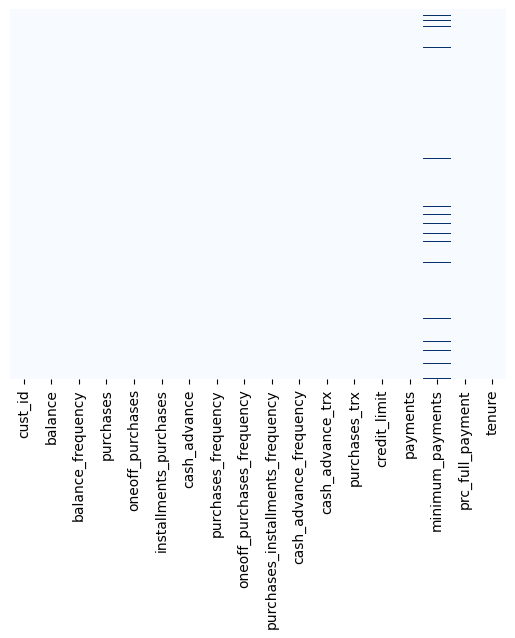

In [13]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap="Blues")

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
balance,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
balance_frequency,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
purchases,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
oneoff_purchases,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
installments_purchases,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
cash_advance,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
purchases_frequency,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
oneoff_purchases_frequency,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
purchases_installments_frequency,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
cash_advance_frequency,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [15]:
d1 = df.dropna()
d1.isna().sum()

,0
cust_id,0
balance,0
balance_frequency,0
purchases,0
oneoff_purchases,0
installments_purchases,0
cash_advance,0
purchases_frequency,0
oneoff_purchases_frequency,0
purchases_installments_frequency,0


In [16]:
df.duplicated().sum()

0

In [17]:
d1.drop("cust_id", axis = 1, inplace= True)

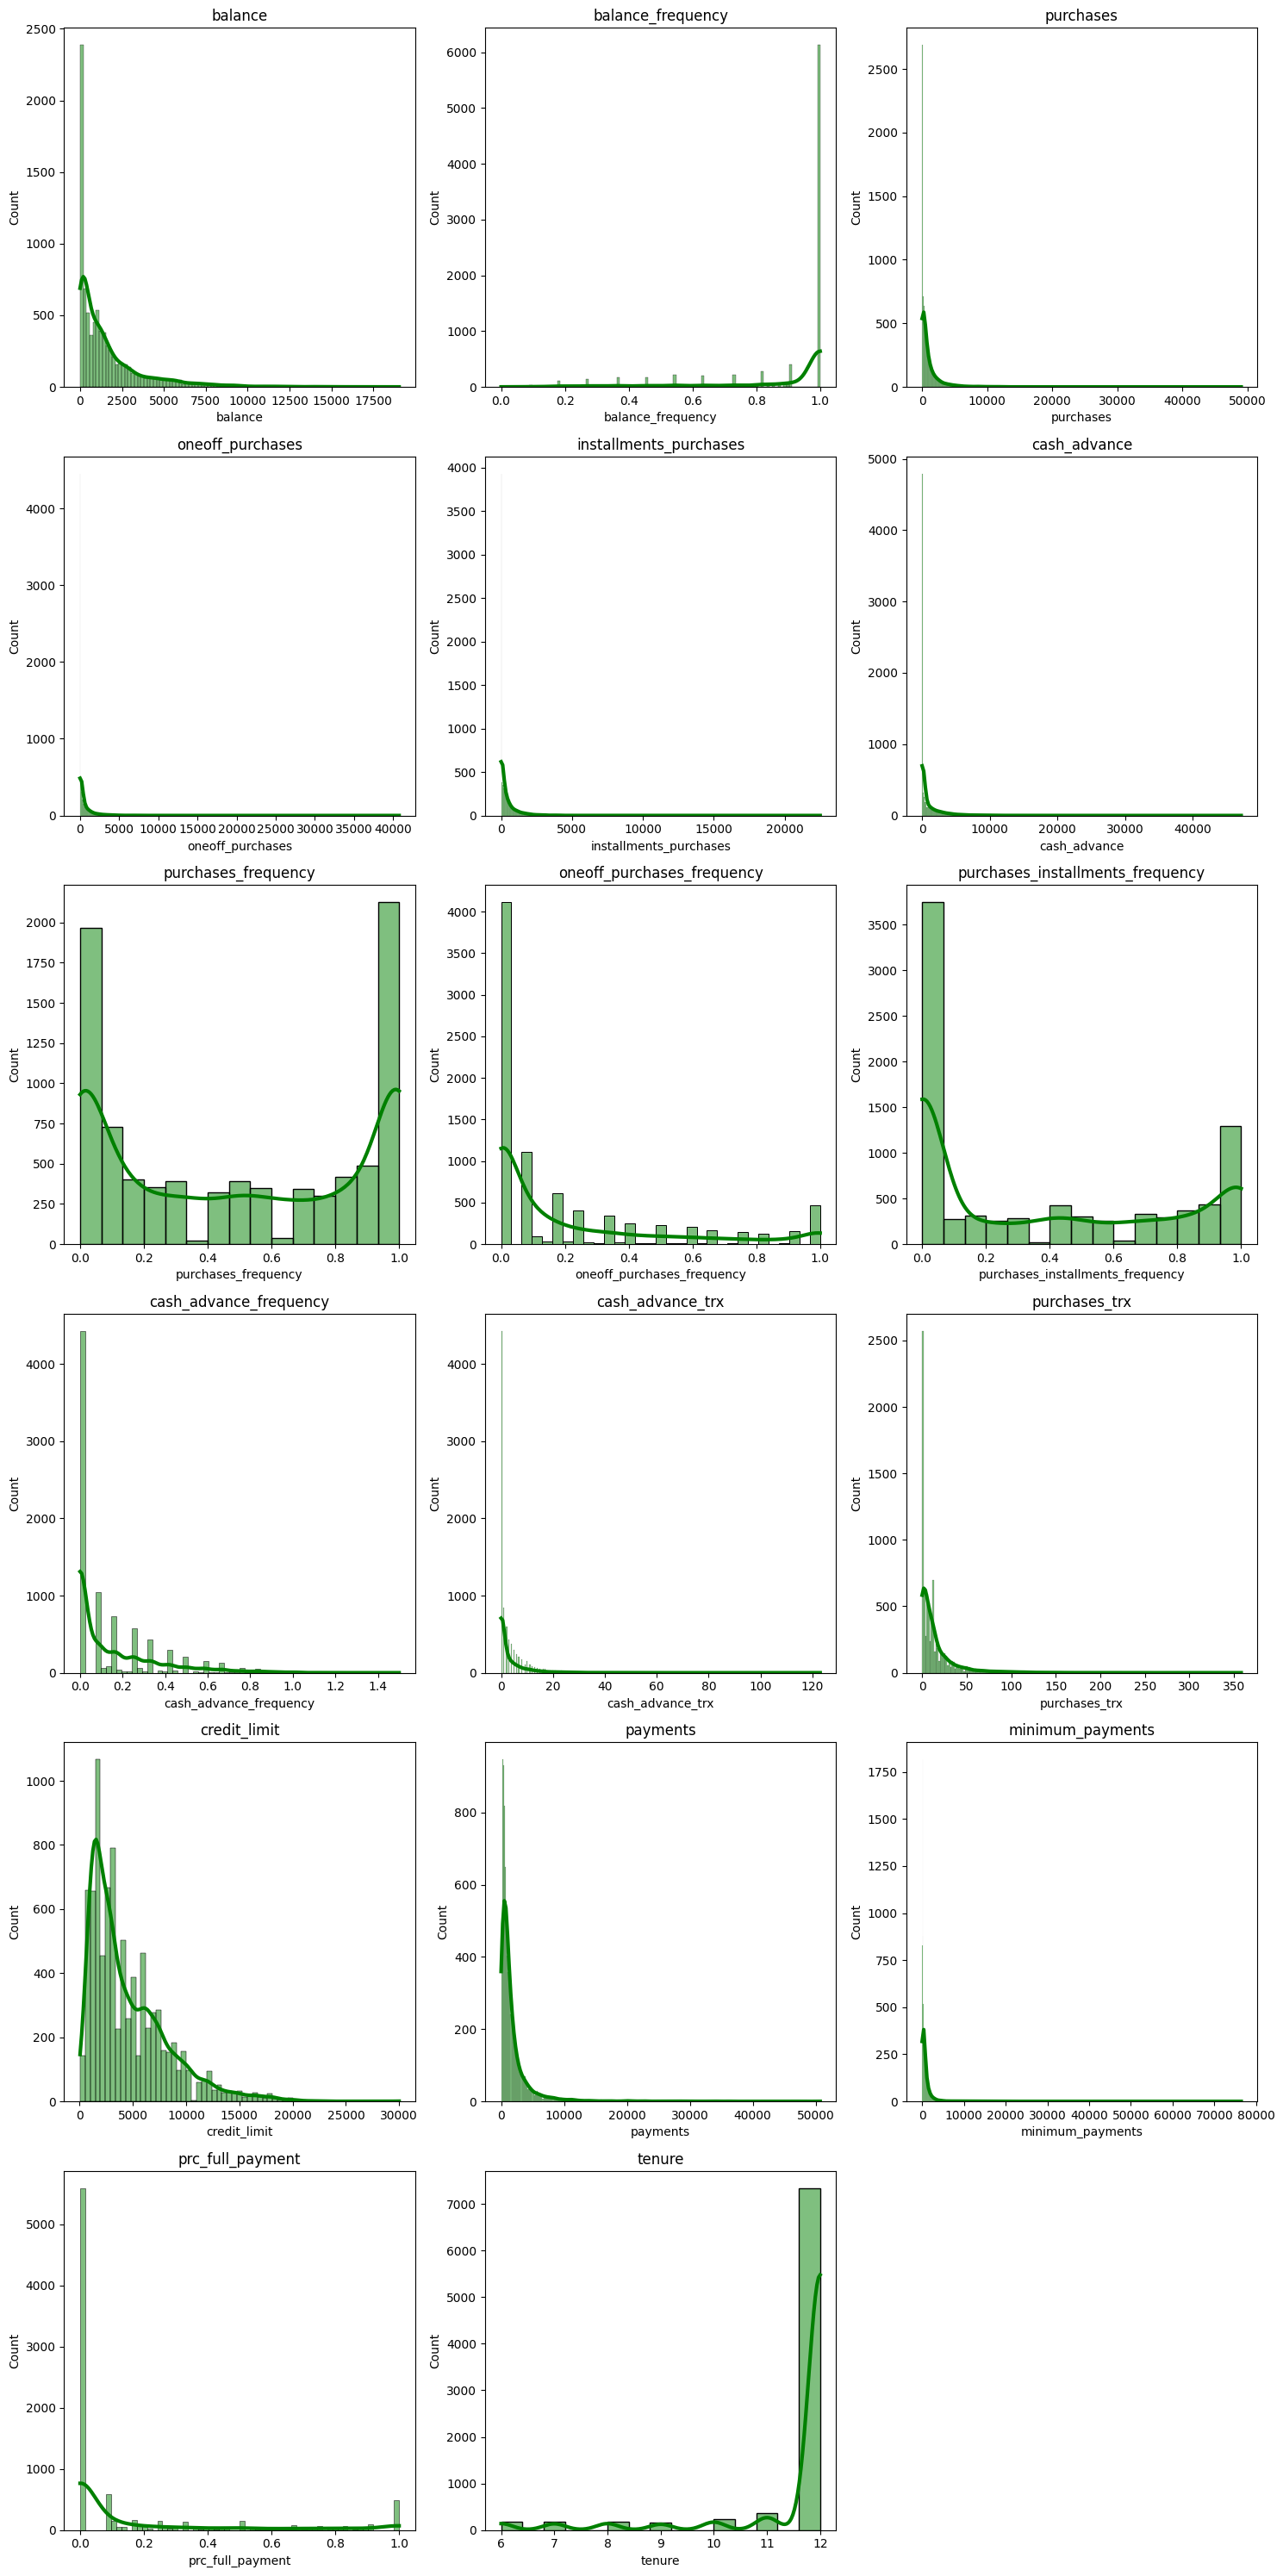

In [19]:
# Calculate the number of rows needed
num_columns = 3
num_rows = (len(d1.columns) + num_columns - 1) // num_columns  # Ceiling division

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column in a separate subplot
for i, column in enumerate(d1.columns):
  sns.histplot(d1[column], kde=True, ax=axes[i], color='g', line_kws={"color": "b", "lw": 3, "label": "KDE"})
  axes[i].set_title(column)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

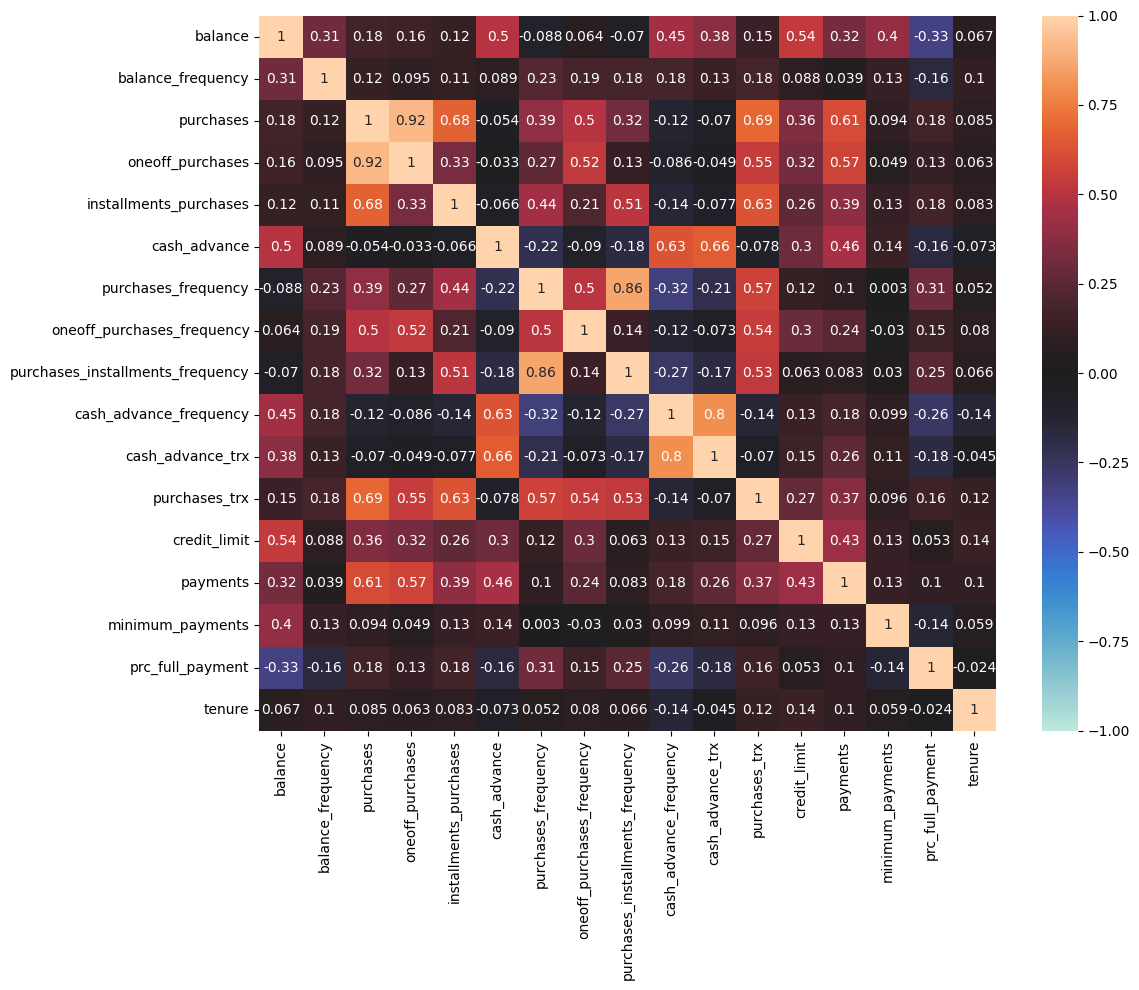

In [21]:
correlations = d1.corr()
f, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(correlations, annot = True, vmin=-1,vmax=1, center=0)
plt.tight_layout()

In [22]:
# nearly 3.5% (313 records) of data in minimum_payments (8637.0 out of 8950) and 0.001% (1 record) in credit_limit (8949.0 out of 8950.0)
# case 1: drop them
# case 2: default filling by mean/median
# case 3: eda to understand the best way to fill them, particularly, minimum_payments

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
from kneed import KneeLocator

# Function to handle missing values
def handle_missing_values(df, strategy='drop', column_specific_strategy=None):
  if strategy == 'drop':
      df = df.dropna()
  elif strategy == 'fill':
      for column in df.columns:
          if column_specific_strategy and column in column_specific_strategy:
              if column_specific_strategy[column] == 'mean':
                  df[column].fillna(df[column].mean(), inplace=True)
              elif column_specific_strategy[column] == 'median':
                  df[column].fillna(df[column].median(), inplace=True)
          else:
              df[column].fillna(df[column].mean(), inplace=True)
  return df

# Function to check for duplicates
def check_duplicates(df):
  duplicates = df.duplicated().sum()
  print(f"Number of duplicate rows: {duplicates}")
  return duplicates

# Function to drop duplicates
def drop_duplicates(df):
  return df.drop_duplicates()

# Function to standardize data
def standardize_data(df, scaler=StandardScaler()):
  return scaler.fit_transform(df),scaler


# Function to load KMeans model and predict
def load_and_predict(df_scaled):
  with open('kmeans_model.pkl', 'rb') as f:
      kmeans = pickle.load(f)
  return kmeans.predict(df_scaled)

# Function to plot histogram of clusters
def plot_clusters(df, labels):
  df['Cluster'] = labels
  df['Cluster'].value_counts().plot(kind='bar')
  plt.title('Cluster Distribution')
  plt.xlabel('Cluster')
  plt.ylabel('Count')
  plt.show()

# Function to rank clusters
def rank_clusters(df, feature):
  cluster_means = df.groupby('Cluster')[feature].mean().sort_values()
  print("Cluster ranking based on feature:", feature)
  print(cluster_means)

def preprocess_dataframe(df):
  # Convert all column names to lowercase
  df.columns = df.columns.str.lower()

  # Remove ID column if it exists
  if 'id' in df.columns:
      df = df.drop(columns=['id'])
  elif 'cust_id' in df.columns:
      df = df.drop(columns=['cust_id'])

  return df

def find_best_k(df_scaled, max_k=20):
  scores = []
  silhouette_scores = []

  for i in range(1, max_k):
      kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
      labels = kmeans.fit_predict(df_scaled)
      scores.append(kmeans.inertia_)

      if i > 1:
          silhouette_scores.append(silhouette_score(df_scaled, labels))
      else:
          silhouette_scores.append(None)

  # Calculate the elbow point using KneeLocator
  krange = range(1, max_k)
  knee_locator = KneeLocator(krange, scores, curve='convex', direction='decreasing')
  elbow_k = knee_locator.elbow

  # Find the best K based on silhouette score
  best_silhouette_k = np.argmax(silhouette_scores[1:]) + 2  # +2 because index starts from 0 and we skip K=1

  # Combine both methods
  # Here, we simply choose the K with the highest silhouette score
  # You can implement a more sophisticated method if needed
  best_k = best_silhouette_k

  # Plotting
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(krange, scores, 'bx-')
  if elbow_k is not None:
      plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at K={elbow_k}')
  plt.title('Elbow Method')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Inertia')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(2, max_k), silhouette_scores[1:], 'bx-')
  plt.axvline(x=best_silhouette_k, color='r', linestyle='--', label=f'Best Silhouette at K={best_silhouette_k}')
  plt.title('Silhouette Scores')
  plt.xlabel('Number of Clusters')
  plt.ylabel('Silhouette Score')
  plt.legend()

  plt.tight_layout()
  plt.show()

  return best_k, elbow_k, best_silhouette_k

def apply_kmeans(df_scaled, best_k):
  kmeans = KMeans(n_clusters=best_k, random_state=42,n_init='auto')
  kmeans.fit(df_scaled)
  with open(f'kmeans_model_{best_k}.pkl', 'wb') as f:
      pickle.dump(kmeans, f)
  return kmeans.labels_, kmeans.cluster_centers_

def translate_output(scaler,cluster_centers, cols):
  cluster_centers = scaler.inverse_transform(cluster_centers)
  cluster_centers = pd.DataFrame(data = cluster_centers, columns = [cols])
  return cluster_centers

def load_kmeans_model(file_path='kmeans_model.pkl'):
  with open(file_path, 'rb') as f:
      kmeans = pickle.load(f)
  return kmeans

def make_predictions(df, kmeans, scaler,cols):
  # Standardize the new data using the same scaler
  df_scaled = scaler.transform(df[cols])
  # Make predictions
  labels = kmeans.predict(df_scaled)
  # Concatenate the labels to the original DataFrame
  df_with_labels = df.copy()
  df_with_labels['cluster'] = labels
  return df_with_labels

Number of duplicate rows: 0


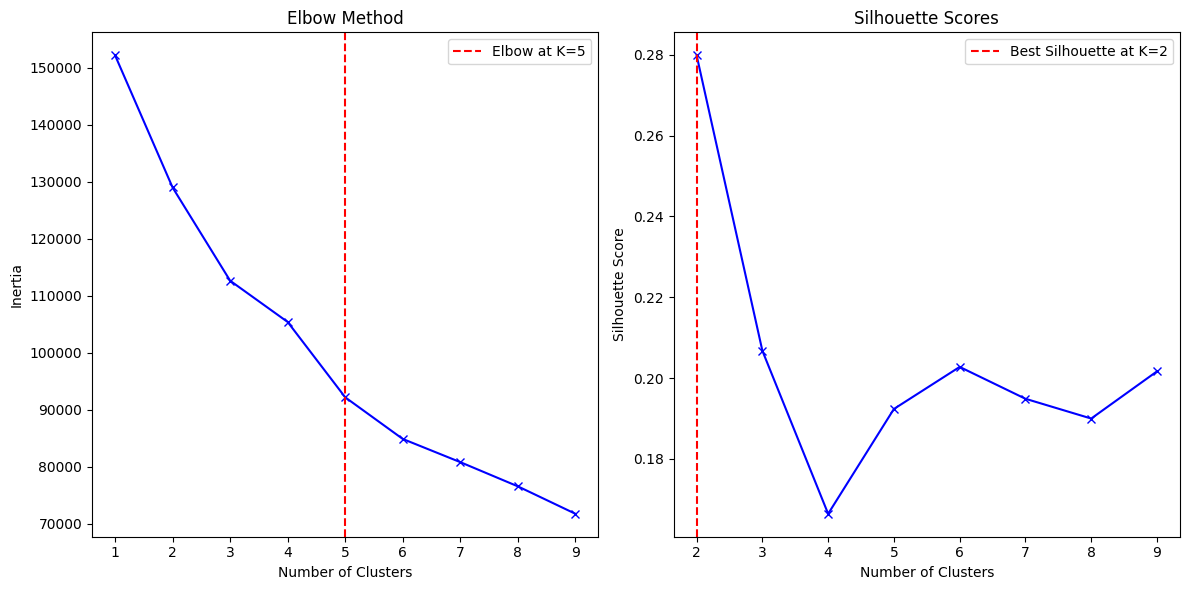

In [124]:
dfc = creditcard_df.copy()
df = preprocess_dataframe(dfc)
df = handle_missing_values(df, strategy='fill', column_specific_strategy={'minimum_payment': 'median'})
check_duplicates(df)
df = drop_duplicates(df)
df_scaled, scaler = standardize_data(df)
best_k, elbow_k, best_silhouette_k = find_best_k(df_scaled,10)

In [125]:
# no agreement between the two methods on the value of K. Move on with both, and see what's more accurate by consulting exp. opinion

In [126]:
elbow_k,best_silhouette_k

(5, 2)

In [127]:
# In order to understand what these numbers mean, let's perform inverse transformation
e_labels, e_cluster_centers = apply_kmeans(df_scaled, best_k=elbow_k)
s_labels, s_cluster_centers = apply_kmeans(df_scaled, best_k=best_silhouette_k)

In [129]:
edf = translate_output(scaler,e_cluster_centers, df.columns.tolist())
sdf = translate_output(scaler,s_cluster_centers, df.columns.tolist())

In [130]:
sdf

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,2151.499003,0.979785,3373.701269,2081.189530,1292.835713,763.943103,0.938276,0.589103,0.71377,0.082474,2.239741,46.270518,7189.551836,3603.015840,1201.737194,0.284948,11.891469
1,1411.309320,0.850523,384.698297,203.994289,180.997983,1034.949821,0.373478,0.101575,0.27329,0.148887,3.512116,6.475063,3791.247194,1245.259529,776.138528,0.119473,11.419696


In [131]:
edf

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,4901.241786,0.967162,551.983377,347.758605,204.327573,4982.037485,0.313364,0.153149,0.203718,0.507043,15.482305,8.587462,8060.469712,3853.894278,2073.175177,0.038165,11.414560
1,3588.990384,0.986874,7815.732886,5203.519089,2613.732785,661.788641,0.944730,0.740963,0.785823,0.071074,2.106329,90.351899,9769.620253,7409.095001,1991.773372,0.291103,11.949367
2,930.357741,0.962886,1299.705338,633.167216,666.735496,226.754889,0.897121,0.313579,0.719275,0.044345,0.828382,23.034766,4272.477078,1388.751132,650.399938,0.264987,11.610303
3,1524.610238,0.965721,255.629606,206.571304,49.407619,792.368773,0.159106,0.090879,0.067320,0.160476,3.035140,2.884072,3241.762452,958.334442,814.901012,0.022044,11.508046
4,111.260364,0.381755,335.222822,199.440295,136.001245,325.747598,0.281932,0.072926,0.198278,0.037617,0.788504,4.279293,3688.455338,1076.939244,264.030094,0.233951,11.270450


In [61]:
s_labels.max(), s_labels.min(), e_labels.max(), e_labels.min()

(1, 0, 5, 0)

In [133]:
epath = 'kmeans_model_6.pkl'
spath = 'kmeans_model_2.pkl'

In [134]:
ekmeans = load_kmeans_model(epath)
skmeans = load_kmeans_model(spath)

In [80]:
epred = make_predictions(dfc.dropna(), ekmeans, scaler, df.columns)
spred = make_predictions(dfc.dropna(), skmeans, scaler, df.columns)

In [135]:
def plot_cluster_histograms(df, column_name, num_clusters=8, num_cols=4):
    num_rows = (num_clusters + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

    for j in range(num_clusters):
        cluster = df[df['cluster'] == j]
        ax = axes[j]
        cluster[column_name].hist(bins=20, ax=ax)
        ax.set_title('{}\nCluster {}'.format(column_name, j))

    # Hide any unused subplots
    for j in range(num_clusters, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

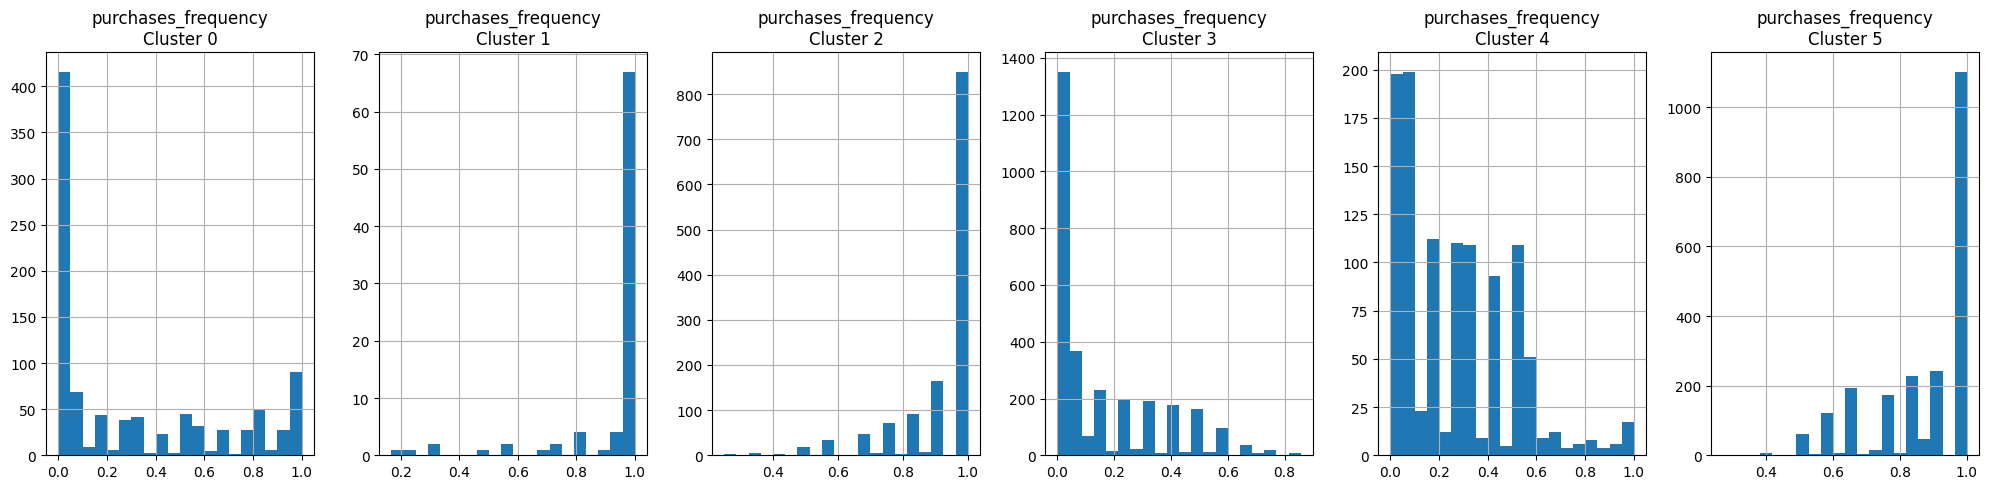

In [94]:
plot_cluster_histograms(df=epred,
                        column_name='purchases_frequency',
                        num_clusters=elbow_k,
                        num_cols=elbow_k)

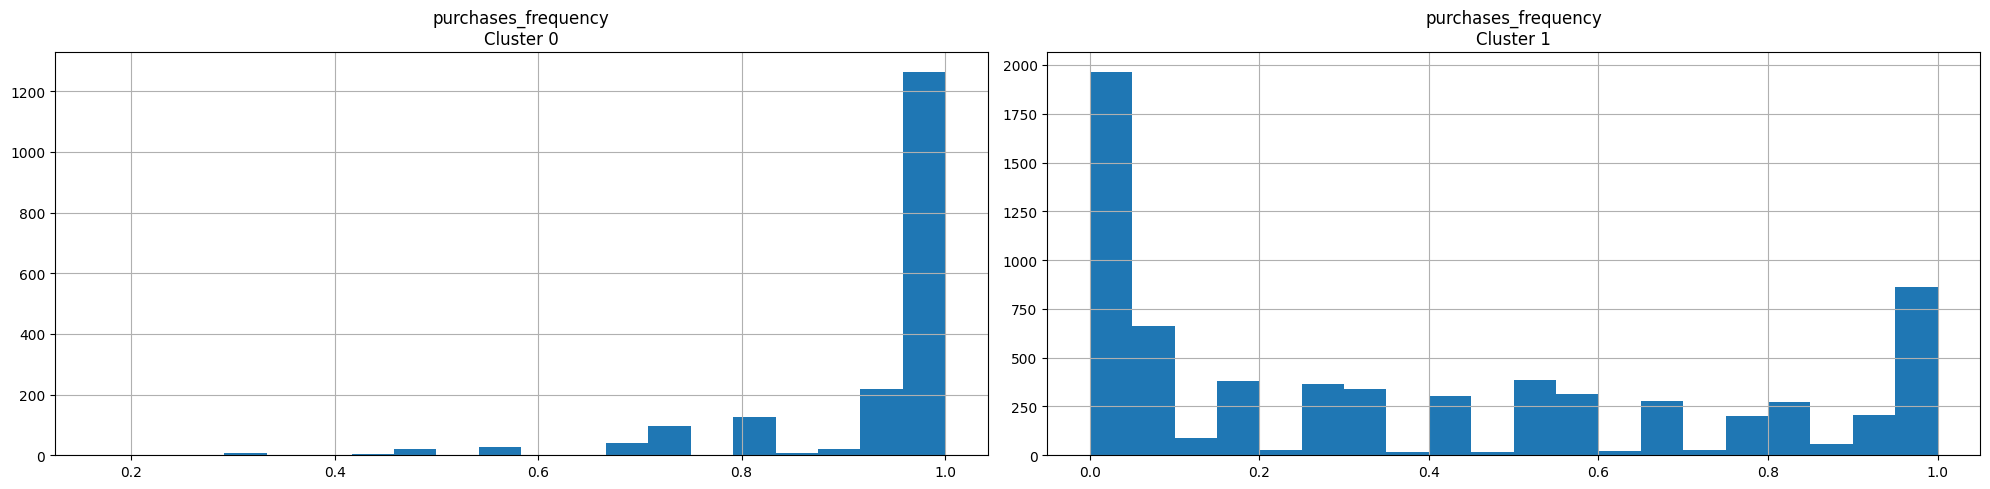

In [96]:
plot_cluster_histograms(df=spred,
                        column_name='purchases_frequency',
                        num_clusters=best_silhouette_k,
                        num_cols=best_silhouette_k)

In [97]:
def plot_cluster_boxplots(creditcard_df_cluster, column_name, num_clusters=8, num_cols=4):
  num_rows = (num_clusters + num_cols - 1) // num_cols  # Calculate the number of rows needed

  fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
  axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

  for j in range(num_clusters):
      cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
      ax = axes[j]
      cluster[column_name].plot(kind='box', ax=ax)
      ax.set_title('{}\nCluster {}'.format(column_name, j))

  # Hide any unused subplots
  for j in range(num_clusters, len(axes)):
      axes[j].set_visible(False)

  plt.tight_layout()
  plt.show()

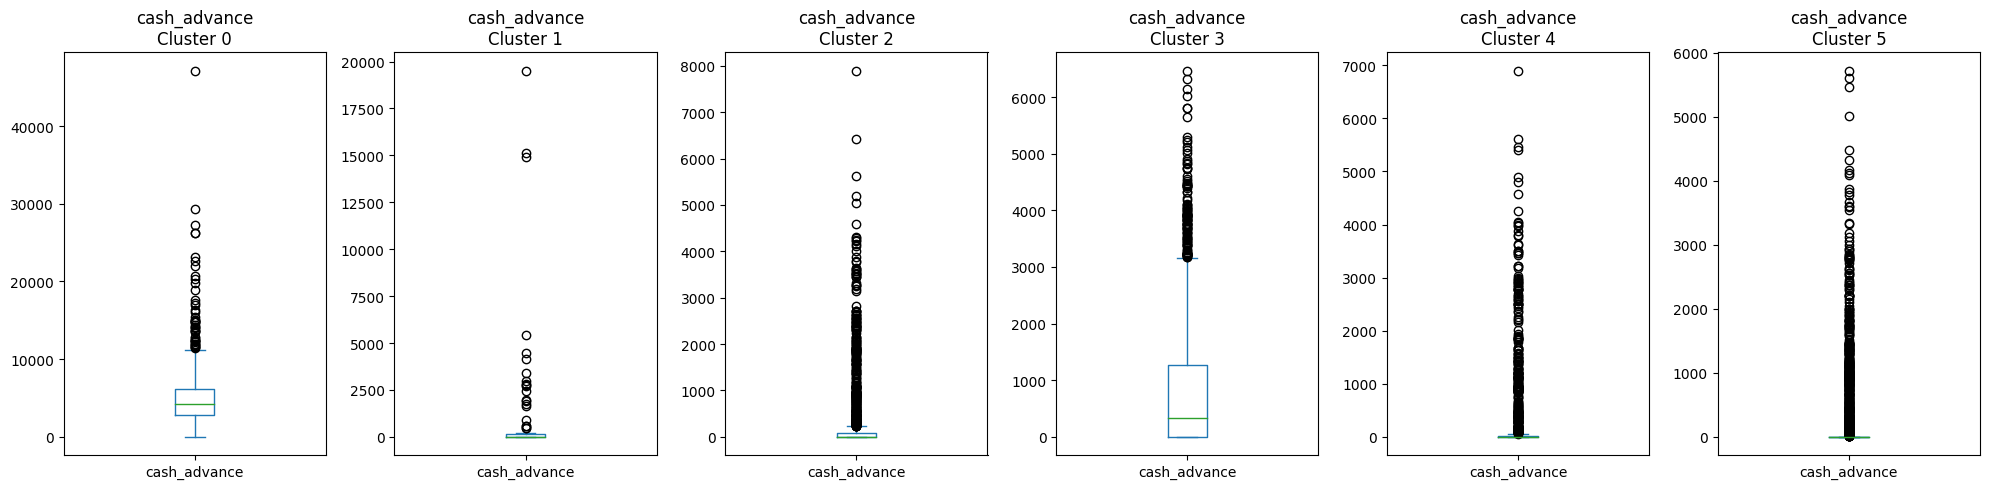

In [99]:
plot_cluster_boxplots(epred, 'cash_advance', elbow_k, elbow_k)

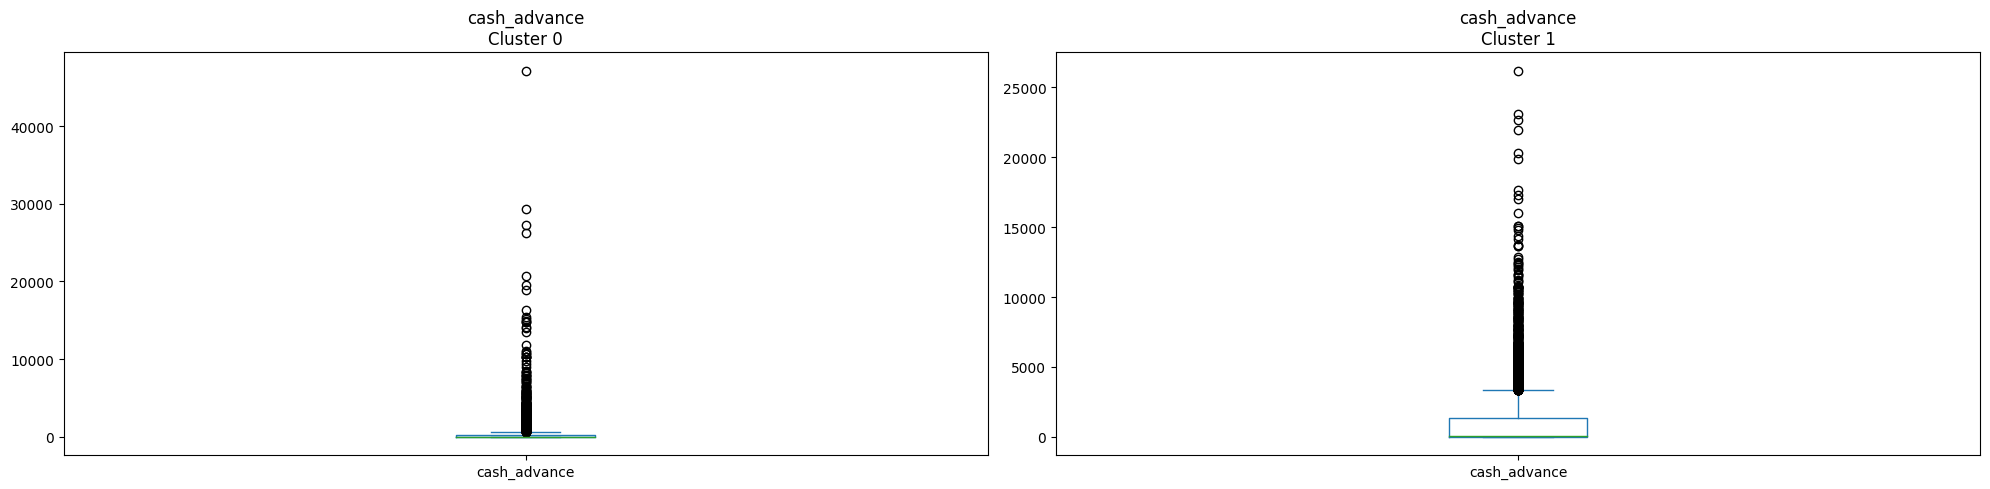

In [101]:
plot_cluster_boxplots(spred, 'cash_advance', best_silhouette_k, best_silhouette_k)

In [108]:
def boxplot_cluster(spred,epred,varname='cash_advance'):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Plot the first boxplot on the first subplot
  axes[0].boxplot([spred[spred['cluster'] == cluster][varname] for cluster in spred['cluster'].unique()],
                  vert=False, patch_artist=True)
  axes[0].set_title('spred Boxplot')
  axes[0].set_yticklabels(spred['cluster'].unique())
  axes[0].set_xlabel(f'{varname}')
  axes[0].set_ylabel('Cluster')

  # Plot the second boxplot on the second subplot
  axes[1].boxplot([epred[epred['cluster'] == cluster][varname] for cluster in epred['cluster'].unique()],
                  vert=False, patch_artist=True)
  axes[1].set_title('epred Boxplot')
  axes[1].set_yticklabels(epred['cluster'].unique())
  axes[1].set_xlabel(f'{varname}')
  axes[1].set_ylabel('Cluster')
  plt.tight_layout()

  # add a legend that count number of samples per cluster, and add to the plot
  #return fig

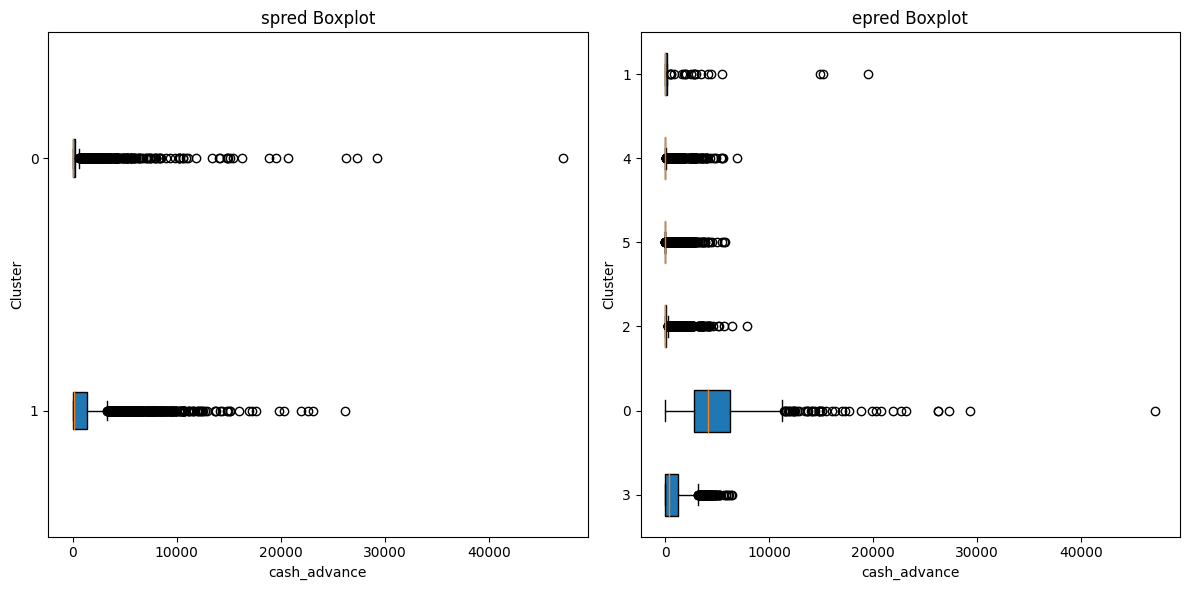

In [109]:
 boxplot_cluster(spred,epred,varname='cash_advance')

In [ ]:
# there is not much of a data distribution beyond K=2, may be an ensemble of the two K methods
# find how how many samples per clusters

In [110]:
def boxplot_cluster(spred, epred, varname='cash_advance'):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

  # Plot the first boxplot on the first subplot
  spred_clusters = spred['cluster'].unique()
  spred_data = [spred[spred['cluster'] == cluster][varname] for cluster in spred_clusters]
  axes[0].boxplot(spred_data, vert=False, patch_artist=True)
  axes[0].set_title('spred Boxplot')
  axes[0].set_yticklabels(spred_clusters)
  axes[0].set_xlabel(varname)
  axes[0].set_ylabel('Cluster')

  # Add sample count to the legend for spred
  spred_counts = [len(spred[spred['cluster'] == cluster]) for cluster in spred_clusters]
  spred_legend = [f'Cluster {cluster}: {count} samples' for cluster, count in zip(spred_clusters, spred_counts)]
  axes[0].legend(spred_legend, loc='upper right')

  # Plot the second boxplot on the second subplot
  epred_clusters = epred['cluster'].unique()
  epred_data = [epred[epred['cluster'] == cluster][varname] for cluster in epred_clusters]
  axes[1].boxplot(epred_data, vert=False, patch_artist=True)
  axes[1].set_title('epred Boxplot')
  axes[1].set_yticklabels(epred_clusters)
  axes[1].set_xlabel(varname)
  axes[1].set_ylabel('Cluster')

  # Add sample count to the legend for epred
  epred_counts = [len(epred[epred['cluster'] == cluster]) for cluster in epred_clusters]
  epred_legend = [f'Cluster {cluster}: {count} samples' for cluster, count in zip(epred_clusters, epred_counts)]
  axes[1].legend(epred_legend, loc='upper right')

  plt.tight_layout()
  plt.show()

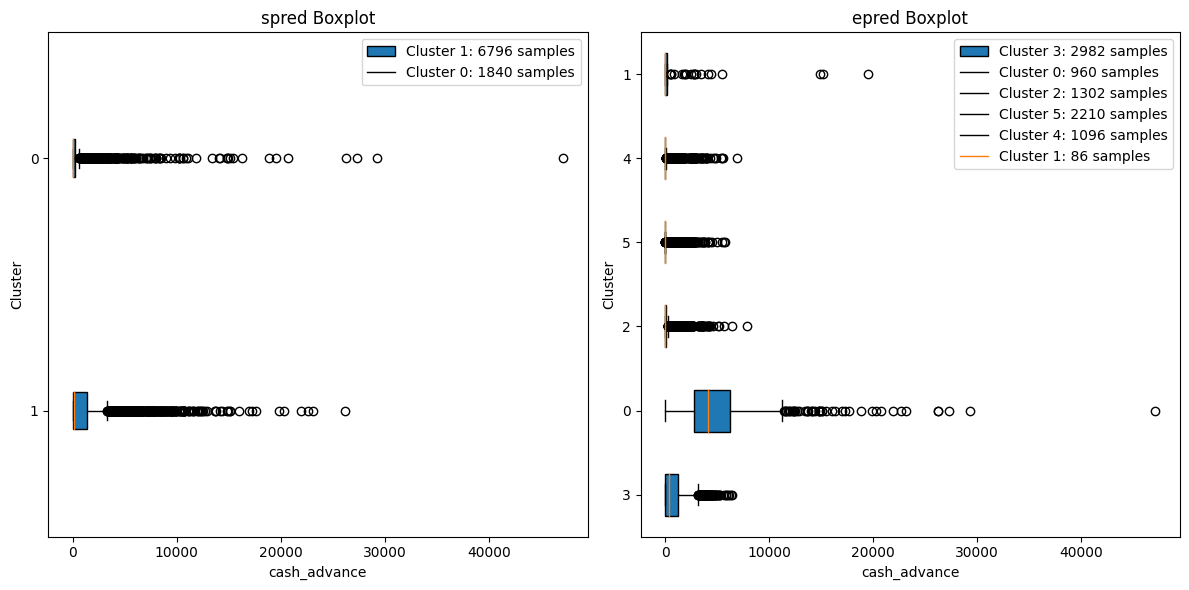

In [111]:
boxplot_cluster(spred,epred,varname='cash_advance')

AutoEncoders